Based on [Credit Card Fraud detection](https://colab.research.google.com/drive/1Jy3IiJenxeEO6TtfctlnZSaoNJo3sIZv?usp=sharing#scrollTo=3HNwy5i02WGN)

In [1]:
import numpy as np
import pandas as pd
from tqdm import tqdm

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    precision_recall_curve, 
    classification_report, 
    confusion_matrix
)
from sklearn.manifold import TSNE

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data_utils
from torch.utils.data import Dataset, DataLoader

from matplotlib import pyplot as plt
import matplotlib.image as img
import seaborn as sns

/opt/homebrew/Caskroom/miniforge/base/envs/transformers/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


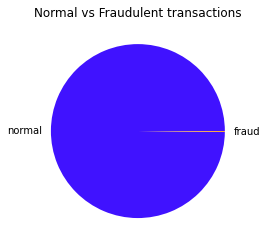

In [2]:
# read data
data = pd.read_csv("../data/creditcard.csv")

# an ugly plot to see distribution of targets
orange, purple = '#ffa022', '#4012ff'
fig, ax = plt.subplots()
ax.pie(
    data.groupby(['Class']).Class.count(),
    labels=['normal', 'fraud'], 
    colors=[purple, orange]
)
plt.title('Normal vs Fraudulent transactions')
plt.show()

In [4]:
# take a random sample of 1000 normal transactions
# and all fraud transactions
non_fraud = data.loc[data['Class']==0].sample(1000)
fraud = data.loc[data['Class']==1]

# shuffle and separate into features and labels
df = non_fraud.append(fraud).sample(frac=1).reset_index(drop=True)
X = df.drop(['Class'], axis=1).values
y = df['Class'].values

/var/folders/5f/7_2jkfbj58x6cf8373dprpfw0000gn/T/ipykernel_6244/1970605312.py:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = non_fraud.append(fraud).sample(frac=1).reset_index(drop=True)


In [5]:
def tsne_plot(X, y, name, title='TSNE plot of Fraud and Non Fraud'):
    tsne = TSNE(
        n_components=2,
        random_state=24,
        learning_rate=200
    )
    x_t = tsne.fit_transform(X)

    plt.figure(figsize=(12,8))
    plt.scatter(
        x_t[np.where(y==0), 0],
        x_t[np.where(y==0), 1],
        color='darkorange',
        alpha=0.7,
        label='Non Fraud'
    )
    plt.scatter(
        x_t[np.where(y==1), 0],
        x_t[np.where(y==1), 1],
        color='mediumblue',
        alpha=0.7,
        label='fraud'
    )

    plt.legend(loc='best')
    plt.title(title, fontsize=16)
    plt.savefig(name)
    plt.show()

/opt/homebrew/Caskroom/miniforge/base/envs/transformers/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:795: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(


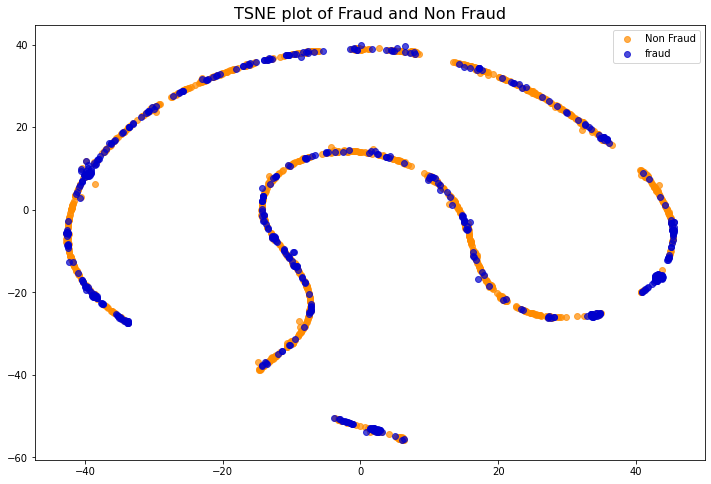

In [6]:
tsne_plot(X, y, name='../images/original.png')

In [8]:
# Convert relative 'Time' measure to hour of day
data["Time"] = data["Time"].apply(
    lambda x: x/3600 % 24
)

# Scale 'Time' and 'Amount'
data['Amount'] = StandardScaler().fit_transform(data['Amount'].values.reshape(-1,1))
data["Time"] = StandardScaler().fit_transform(data['Time'].values.reshape(-1,1))

# separate fraudulent transactions from normal transactions
norm_data, fraud_data = data.loc[data['Class']==0], data.loc[data['Class']==1]

# based on source asumptions
# Training data will be 2000 normal samples
# Validation data will be 1000 samples, approximately half fraud and half normal samples; shuffled and with indices reset
# We leave out 200 normal samples and 50 fraud samples for a final test dataset of 250 unseen samples; we'll choose a random subsample of these later
train_data = norm_data.iloc[:2000, :]
val_data = pd.concat(
    [norm_data.iloc[2000:2558,:], fraud_data.iloc[:442, :]],
    axis=0
).sample(frac=1).reset_index(drop=True)
test_samples = pd.concat(
    [norm_data.iloc[2558:2608], fraud_data.iloc[442:,:]],
    axis=0
).sample(frac=1).reset_index(drop=True)

**Asumption to use Autoencoders:**</br>
Autoencoders learn an implicit representation of normality from the abundant “normal” samples, allowing us to reserve our sparse fraudulent data samples for testing

In [9]:
# define hyperparameters
hyper_params = {
    'learning_rate': 1e-1/10,
    'epochs': 150,
    'batch_size': 32,
    'weight_decay': 1e-8,
    'threshold': 0.75
}

In [10]:
# create dataloaders for training and validation sets
train_target = torch.tensor(
    train_data['Class'].values.astype(np.float32)
)
train = torch.tensor(
    train_data.drop('Class', axis=1).values.astype(np.float32)
)
train_tensor = data_utils.TensorDataset(train, train_target)
train_loader = data_utils.DataLoader(
    dataset=train_tensor,
    batch_size=hyper_params['batch_size'],
    shuffle=True
)

# val
val_target = torch.tensor(
    val_data['Class'].values.astype(np.float32)
)
val = torch.tensor(
    val_data.drop('Class', axis=1).values.astype(np.float32)
)
val_tensor = data_utils.TensorDataset(val, val_target)
val_loader = data_utils.DataLoader(
    dataset=val_tensor,
    batch_size=1,
    shuffle=True
)

In [11]:
class Autoencoder(nn.Module):
    def __init__(self,):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(30, 14),
            nn.Tanh(),
            nn.Linear(14, 7),
            nn.Tanh(),
        )
        self.decoder = nn.Sequential(
            nn.Linear(7, 14),
            nn.Tanh(),
            nn.Linear(14, 30),
            nn.Tanh()
        )
    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [12]:
model = Autoencoder()
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(
    model.parameters(),
    lr=hyper_params['learning_rate'],
    weight_decay=hyper_params['weight_decay']
)

In [14]:
for epoch in range(hyper_params['epochs']):
    losses = []
    for (data, _) in train_loader:
        # forward
        output = model(data)
        loss = criterion(output, data)
        # backward
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        losses.append(loss.detach().cpu().numpy())

        losses = []
        labels = []
        preds = []
        embeds = []

        for data, label in val_loader:
            # forward
            reconstructed = model(data)
            loss = torch.sigmoid(criterion(reconstructed, data)).item()
            losses.append(round(loss, 6))
            labels.append(label.item())
            preds.append(reconstructed[0][-1].item())
            embeds.append(reconstructed[0][:-1].detach().cpu().numpy())

        if epoch == (hyper_params['epochs'] - 1):
            print('logging table')
            df = pd.DataFrame()
            df['Reconstructed_Loss'] = losses
            df['Labels_gt'] = labels
            df['Labels_preds'] = [int(x>=hyper_params['threshold']) for x in losses]
print('Complete')

KeyboardInterrupt: 